In [1]:
import os 
from pathlib import Path
import pandas as pd 
import re
import utils
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from sklearn.metrics import f1_score

c:\Users\DELLPHOTO\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Se leen los datos y se seleccionan las variables que presentan una diferencia
# entre los individuos que presentan estres y los que no
data_path = Path(os.getcwd()).parent / "data"
silver_path = data_path / "silver" / "dreadditCleanTest.csv"
df = pd.read_csv(silver_path)

In [3]:
#Configuracion de visualizaciones 

# Configurar el estilo de fondo con una cuadrícula
sns.set_style("whitegrid")

# Establecer una paleta de colores profesional
sns.set_palette(['#2596be'])

# Configurar la tipografía y el tamaño de la fuente
sns.set_context("paper", font_scale=1.5, rc={"font.family": "sans-serif", "font.sans-serif": ["Helvetica", "Arial"]})

# Desactivar spines innecesarios
sns.despine(trim=True, left=True);

<Figure size 640x480 with 0 Axes>

In [4]:
scores = {}


#### Caracteristicas extraidas a mano

In [5]:
X = df[["singular_pronouns","adj_adv"]]
y = df.label

In [6]:
models_path = Path(os.getcwd()).parent / "models"


# Lista para almacenar los nombres de archivos
pkl_files = []

# Recorre todos los archivos en el directorio especificado
for filename in os.listdir(models_path):
    if (filename.endswith('.pkl') & ("manual" in filename)):
        pkl_files.append(filename)

for model_name in pkl_files:
    ruta = os.path.join(models_path,model_name)
    # Cargar el modelo
    with open(ruta, 'rb') as file:
        model = pickle.load(file)

    f1s= np.round(utils.evaluate_model(model, X,y).mean(),3)
    scores[model_name.split(".")[0]] = f1s

#### Solo TF-IDF

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')

features = tfidf.fit_transform(df["clean_text"]).toarray()

X,y = pd.DataFrame(features),df.label

In [8]:
# Lista para almacenar los nombres de archivos
pkl_files = []

# Recorre todos los archivos en el directorio especificado
for filename in os.listdir(models_path):
    if (filename.endswith('.pkl') & ("TFIDF" in filename)):
        pkl_files.append(filename)

for model_name in pkl_files:
    ruta = os.path.join(models_path,model_name)
    # Cargar el modelo
    with open(ruta, 'rb') as file:
        model = pickle.load(file)

    f1s= np.round(utils.evaluate_model(model, X,y).mean(),3)
    scores[model_name.split(".")[0]] = f1s

#### Both

In [9]:
features = tfidf.fit_transform(df["clean_text"]).toarray()

X,y = pd.DataFrame(features),df.label

X['singular_pronouns'] = df['singular_pronouns']
X['adj_adv'] = df['adj_adv']

In [10]:
# Lista para almacenar los nombres de archivos
pkl_files = []

# Recorre todos los archivos en el directorio especificado
for filename in os.listdir(models_path):
    if (filename.endswith('.pkl') & ("both" in filename)):
        pkl_files.append(filename)

for model_name in pkl_files:
    ruta = os.path.join(models_path,model_name)
    # Cargar el modelo
    with open(ruta, 'rb') as file:
        model = pickle.load(file)

    f1s= np.round(utils.evaluate_model(model, X.values,y).mean(),3)
    scores[model_name.split(".")[0]] = f1s

#### RoBERTa

In [11]:
rmodel = os.path.join(models_path,"saved_roberta_model")


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = rmodel
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.to(device);


In [13]:
res= df.text.apply(utils.make_prediction,args=(model,tokenizer, device))

In [14]:
y = df.label 
y_pred =res.apply(lambda x: x[1])

In [15]:
scores["RoBERTa"] = f1_score(y, y_pred)

In [16]:
scores = pd.DataFrame.from_dict(scores, orient="index").reset_index()
scores.columns=["model","fscore"]


In [17]:
scores = scores.sort_values("fscore", ascending=False)

C:\Users\DELLPHOTO\AppData\Local\Temp\ipykernel_8876\1855271777.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="fscore",y="model",data=scores, palette=colors_pal)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

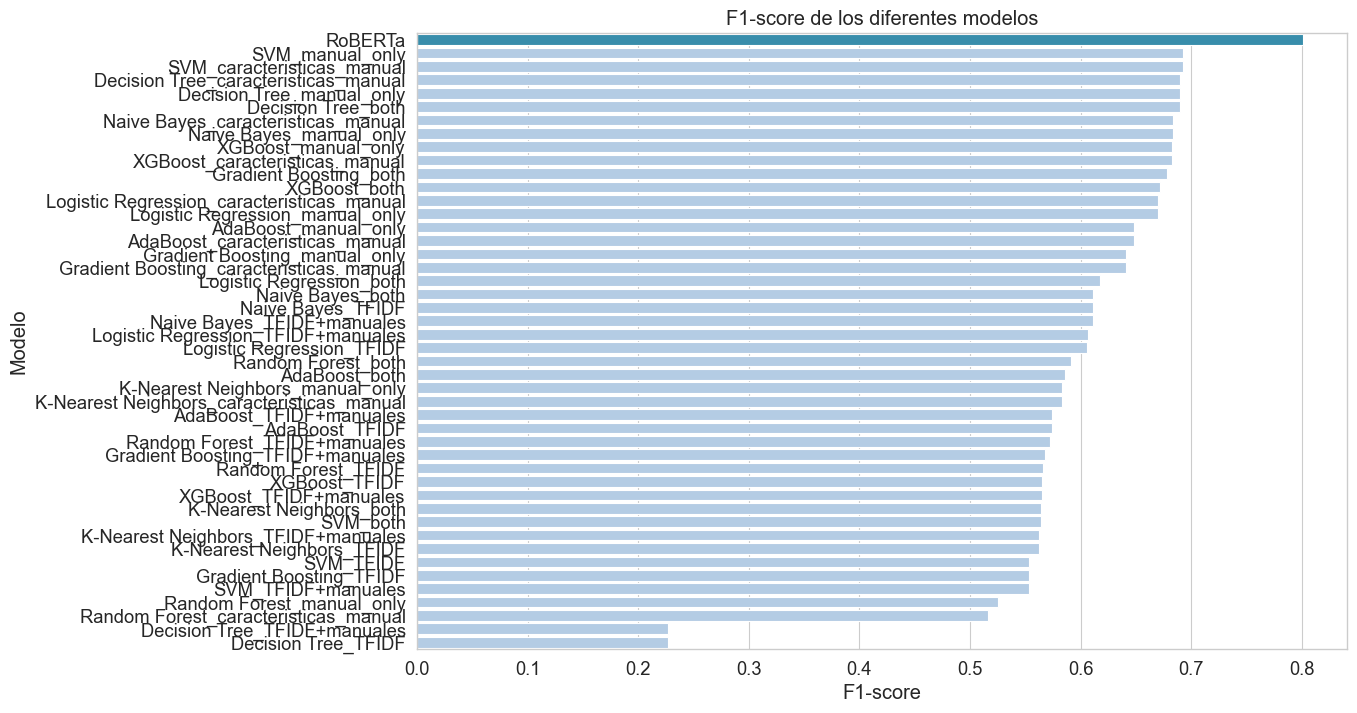

In [18]:

# Palabras que deben tener un color especial
special_words = ['RoBERTa']

# Función para aplicar colores
def assign_colors(words, special_words, color_special, color_default):
    return [color_special if word in special_words else color_default for word in words]

# Colores por defecto y especial
default_color = '#acccec'  # Azul por defecto
special_color = '#2596be'  

# Aplicar la función de asignación de colores
colors_pal = assign_colors(scores['model'], special_words, special_color, default_color)

fig, axes = plt.subplots(figsize=(12, 8))
plt.title("F1-score de los diferentes modelos")
sns.barplot(x="fscore",y="model",data=scores, palette=colors_pal)
plt.xlabel("F1-score")
plt.ylabel("Modelo")
plt.tight_layout